In [35]:
%matplotlib inline

# TODO: update Postgres Git :)

In [70]:
import re
import sqlite3
from datetime import datetime

import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np

con = sqlite3.connect('main.db')

project_name = 'postgres'

sql = f'''
select tag, date(creator_dt)
from projects join releases on projects.id = releases.project_id
where name = '{project_name}'
and tag like 'REL_%' and tag not like 'REL2%'
and tag not like 'release%'
and tag not like '%ALPHA%'
and tag not like '%beta%'
and tag not like '%RC%'
'''
raw_releases = con.execute(sql).fetchall()
print(['RAW:'] + raw_releases[:3] + raw_releases[-3:])

def is_interesting(rtag):
    return rtag.startswith('REL_1') or re.match(r'REL[0-9].[0-9]+_0$', rtag)

def strip_prefix(rtag):
    if rtag.startswith('REL_'):
        return rtag[4:]
    return rtag[3:]

releases = list(rel for rel in raw_releases if is_interesting(rel[0]))
print(len(releases))

print(releases[:3])
names = [strip_prefix(row[0]) for row in releases]
dates = [row[1] for row in releases]
dates = [datetime.strptime(d, "%Y-%m-%d") for d in dates]
print(dates[:3])

['RAW:', ('REL6_1', '1997-06-13'), ('REL6_1_1', '1997-07-21'), ('REL6_2', '1997-10-02'), ('REL_11_1', '2018-11-06'), ('REL_11_2', '2019-02-11'), ('REL_11_3', '2019-05-06')]
25
[('REL8_0_0', '2005-01-17'), ('REL8_1_0', '2005-11-05'), ('REL8_2_0', '2006-12-02')]
[datetime.datetime(2005, 1, 17, 0, 0), datetime.datetime(2005, 11, 5, 0, 0), datetime.datetime(2006, 12, 2, 0, 0)]


[(datetime.datetime(2005, 1, 17, 0, 0), -5, '8_0_0'), (datetime.datetime(2005, 11, 5, 0, 0), 5, '8_1_0'), (datetime.datetime(2006, 12, 2, 0, 0), -3, '8_2_0'), (datetime.datetime(2008, 2, 1, 0, 0), 3, '8_3_0'), (datetime.datetime(2009, 6, 27, 0, 0), -1, '8_4_0'), (datetime.datetime(2010, 9, 17, 0, 0), 1, '9_0_0'), (datetime.datetime(2011, 9, 8, 0, 0), -5, '9_1_0'), (datetime.datetime(2012, 9, 6, 0, 0), 5, '9_2_0'), (datetime.datetime(2013, 9, 2, 0, 0), -3, '9_3_0'), (datetime.datetime(2014, 12, 16, 0, 0), 3, '9_4_0'), (datetime.datetime(2016, 1, 4, 0, 0), -1, '9_5_0'), (datetime.datetime(2016, 9, 26, 0, 0), 1, '9_6_0'), (datetime.datetime(2017, 10, 2, 0, 0), -5, '10_0'), (datetime.datetime(2017, 11, 7, 0, 0), 5, '10_1'), (datetime.datetime(2018, 2, 5, 0, 0), -3, '10_2'), (datetime.datetime(2018, 2, 26, 0, 0), 3, '10_3'), (datetime.datetime(2018, 5, 7, 0, 0), -1, '10_4'), (datetime.datetime(2018, 8, 6, 0, 0), 1, '10_5'), (datetime.datetime(2018, 11, 5, 0, 0), -5, '10_6'), (datetime.datet

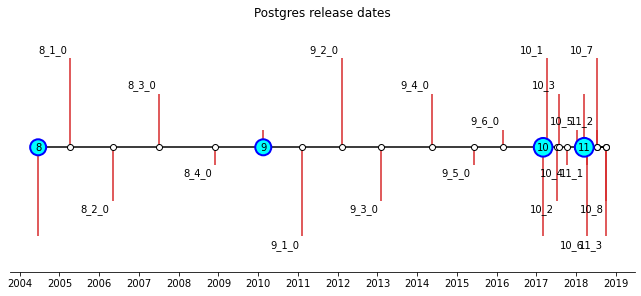

<Figure size 432x288 with 0 Axes>

In [67]:
# Choose some nice levels
levels = np.tile([-5, 5, -3, 3, -1, 1],
                 int(np.ceil(len(dates)/6)))[:len(dates)]

# Create figure and plot a stem plot with the date
fig, ax = plt.subplots(figsize=(8.8, 4), constrained_layout=True)

ax.vlines(dates, 0, levels, color="tab:red")  # The vertical stems.
ax.plot(dates, np.zeros_like(dates), "-o",
        color="black", markerfacecolor="white")  # Baseline and markers on it.

def is_major(rel):
        if rel.startswith('1'):
                return rel.endswith('_0')
        return rel.endswith('0_0')

releases = list(zip(dates, levels, names))
print(releases[:3])

# annotate minor releases with lines
min_style = dict(textcoords="offset points",
                horizontalalignment="right")
for a_date, a_level, name in releases:
        if is_major(name):
                continue
        ax.annotate(name, xy=(a_date, a_level),
                xytext=(-3, np.sign(a_level)*3),
                verticalalignment="bottom" if a_level > 0 else "top",
                **min_style)

# major release gets big blue circle
major_style = dict(
        size=10, ha="center", va="center", # rotation=45, 
        bbox=dict(boxstyle="circle,pad=0.3", fc="cyan", ec="b", lw=2)
)
for a_date, a_level, name in releases:
        if not is_major(name):
                continue
        major_name = re.match('[0-9]+', name).group(0) # major version only
        t = ax.text(
                a_date, 0, major_name, 
                **major_style)

ax.xaxis.set_major_locator(mdates.MonthLocator(interval=12))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))

ax.set(title=f"{project_name.title()} release dates")

# remove y axis and spines
ax.yaxis.set_visible(False)
ax.spines[["left", "top", "right"]].set_visible(False)
ax.margins(y=0.2)

plt.show()

plt.savefig(f"{project_name}-releases.png")